<a href="https://colab.research.google.com/github/aadityadamle/Copy-of-Toxic-Content-Detector-/blob/master/ToxicCommentDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import transformers
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print("Running with TPU",tpu.master())
except ValueError:
  tpu =None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
  strategy = tf.distribute.get_strategy()



INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running with TPU grpc://10.70.10.130:8470


In [4]:
!wget https://raw.githubusercontent.com/abcom-mltutorials/detecting-slang/master/jigsawdata.zip

--2020-07-27 06:06:06--  https://raw.githubusercontent.com/abcom-mltutorials/detecting-slang/master/jigsawdata.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51915053 (50M) [application/zip]
Saving to: ‘jigsawdata.zip.1’

jigsawdata.zip.1    100%[===================>]  49.51M  81.7MB/s    in 0.6s    

2020-07-27 06:06:07 (81.7 MB/s) - ‘jigsawdata.zip.1’ saved [51915053/51915053]



In [5]:
!unzip '/content/jigsawdata.zip'

Archive:  /content/jigsawdata.zip
replace bert toxix/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bert toxix/test.csv     
replace bert toxix/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bert toxix/train.csv    


In [7]:
train = pd.read_csv("/content/bert toxix/train.csv")
test = pd.read_csv('/content/bert toxix/test.csv')

In [8]:
train[train["toxic"]==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


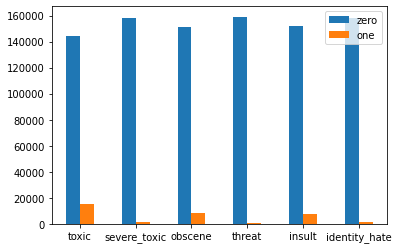

In [9]:
columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
zeros =[]
ones =[]
for col in columns:
  zeros.append(train[col].value_counts()[0])
  ones.append(train[col].value_counts()[1])
  
df = pd.DataFrame({'zero': zeros,'one': ones}, index=columns)
df.plot.bar(rot=0)

In [13]:
def build_model(transformer, loss, max_len = 512):
  input_word_ids = Input(shape=(max_len,), dtype = tf.int32, name = "input_word_ids")
  sequence_output = transformer(input_word_ids)[0]
  cls_token = sequence_output[:,0,:]
  x = tf.keras.layers.Dropout(0.35)(cls_token)
  out = Dense(1, activation = "sigmoid")(x)

  model = Model(inputs = input_word_ids, outputs = out)
  model.compile(Adam(lr =3e-5), loss = loss, metrics = [tf.keras.metrics.AUC()])
  return model

In [14]:
def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * 
                       K.pow(1. - pt_1, gamma) * 
                       K.log(pt_1)) - K.mean((1 - alpha) * 
                       K.pow(pt_0, gamma) * 
                       K.log(1. - pt_0))
    return focal_loss_fixed

In [15]:
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Data Preprocessing

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [19]:
#Saving tokenizer
save_path = "distilbert_base_uncased/"
if not os.path.exists(save_path):
  os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('distilbert_base_uncased/vocab.txt',
 'distilbert_base_uncased/special_tokens_map.json',
 'distilbert_base_uncased/added_tokens.json')

In [20]:
fast_tokenizer = BertWordPieceTokenizer("distilbert_base_uncased/vocab.txt", lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [26]:
def fast_encode(texts, tokenizer, chunk_size = 256, maxlen = 512):
  tokenizer.enable_truncation(max_length = maxlen)
  tokenizer.enable_padding(length = maxlen)
  all_ids = []

  for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
  return np.array(all_ids)


In [27]:
x = fast_encode(train.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_test = fast_encode(test.comment_text.astype(str), fast_tokenizer, maxlen=512)
y = train.toxic.values


In [28]:
#preparing train data set
BATCH_SIZE=64

train_dataset = (
    tf.data.Dataset 
      .from_tensor_slices((x, y))
      .repeat()
      .shuffle(2048)
      .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE) 
)

In [29]:
#preparing test data set
test_data = (
    tf.data.Dataset# create dataset
    .from_tensor_slices(x_test) 
    .batch(BATCH_SIZE)
)

In [30]:
#model training
with strategy.scope():
  train_history = model.fit(
      train_dataset,
      
      steps_per_epoch=150,
      
      epochs=10
  )

Epoch 1/10
150/150 [==============================] - 43s 286ms/step - loss: 0.0398 - auc: 0.5738
Epoch 2/10
150/150 [==============================] - 43s 286ms/step - loss: 0.0189 - auc: 0.9339
Epoch 3/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0139 - auc: 0.9742
Epoch 4/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0128 - auc: 0.9755
Epoch 5/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0116 - auc: 0.9799
Epoch 6/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0117 - auc: 0.9817
Epoch 7/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0121 - auc: 0.9792
Epoch 8/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0111 - auc: 0.9833
Epoch 9/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0116 - auc: 0.9800
Epoch 10/10
150/150 [==============================] - 43s 287ms/step - loss: 0.0104 - auc: 0.9848


In [31]:
test['toxic'] = model.predict(test_data, verbose=1)

2394/2394 [==============================] - 219s 91ms/step


In [32]:
# saving result to a csv file
test.to_csv('test.csv', index=False)
data=pd.read_csv('/content/test.csv')
data.head()

,id,comment_text,toxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.973981
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.011204
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.025830
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.007493
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.015357


In [33]:
def replace(toxic):
  if toxic >=0.5:
    toxic=1
  else:
    toxic=0
  return toxic

test['prediction']=test['toxic'].apply(lambda x : replace(x))

In [35]:
# data after adding the predictions column which converts probabilities to 1 or 0
test

,id,comment_text,toxic,prediction
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.973981,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.011204,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.025830,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.007493,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.015357,0
...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0.534214,1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0.068871,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0.016806,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0.018735,0


Text(0, 0.5, 'count')

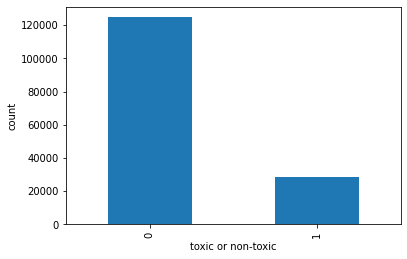

In [36]:
test.prediction.value_counts().plot(kind='bar')
plt.xlabel('toxic or non-toxic')
plt.ylabel('count')

In [37]:
#randomly chosen text
text1=test.comment_text[153]
text1

":Another item that should be considered: WP's goal to serious institution and its policy not to hurt people gratuitously apply to all articles, regardless if their subjects are living or dead."

In [38]:
# modified fast_encode function to encode given text
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    encs = tokenizer.encode_batch(texts)
    all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [39]:
#prediction
p1=fast_encode([text1], fast_tokenizer, maxlen=512)
p1 = model.predict(p1)
if (replace(p1) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Okay contents


In [45]:
text2=test.comment_text[86]
text2

'":::If you email me I\'ll reply with a copy of the Pignotti pdf.  It\'s not at all controversial that EFT show more of an effect than some treatments in some conditions.  The problem is that EFT doesn\'t show more of an effect than talking and tapping your arm or talking and tapping a doll.   \n\n :::Second, I think you\'re not being quite forthright when you describe the accupressure citations as ""controvert[ing] this conclusion"".  In fact, you removed the last two and silently changed the other two.  If you want to change text that someone has already responded to, please use  and <\\s>, like this, so it doesn\'t look like you\'re being sneaky.  This also looks like you\'re throwing in every citation you can find without reading or understanding them, hoping something will stick.  If you recall, I asked for one pdf and we\'re now at numbers 16 and 17 and you\'re just now learning what the issues are.  And, after taking a look, neither one of your new studies has anything to do wit

In [46]:
p2=fast_encode([text2], fast_tokenizer, maxlen=512)
p2=model.predict(p2)
if (replace(p2) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Okay contents


In [47]:
#unseen content 
text3  = ["Moments its musical age explain. But extremity sex now education concluded earnestly her continual. Oh furniture acuteness suspected continual ye something frankness. Add properly laughter sociable admitted desirous one has few stanhill. Opinion regular in perhaps another enjoyed no engaged he at. It conveying he continual ye suspected as necessary. Separate met packages shy for kindness. "]

In [48]:
p3=fast_encode(text3, fast_tokenizer, maxlen=512)
p3=model.predict(p3)
if (replace(p2) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Okay contents
